In [1]:
import os

In [2]:
import zipfile

In [3]:
os.listdir('./aug_train1')

['1gr', '2gr', '3gr']

In [4]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [5]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

c:\users\paperspace\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\paperspace\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
!pip install h5py scikit-optimize

keras-applications 1.0.2 has requirement keras>=2.1.6, but you'll have keras 2.1.3 which is incompatible.
keras-preprocessing 1.0.1 has requirement keras>=2.1.6, but you'll have keras 2.1.3 which is incompatible.


In [7]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args


In [8]:
datagen_train = ImageDataGenerator(
      rescale=1./128)

In [9]:
datagen_test = ImageDataGenerator(rescale=1./128)

In [10]:
epochs=2
batch_size = 10
steps_per_epoch_train=9000//128
steps_per_epoch_val=152//10


In [11]:

generator_train = datagen_train.flow_from_directory(directory='./aug_train1',
                               
                                                    target_size=(224,224),
                                                    batch_size=128,
                                                    class_mode='categorical',shuffle=True)

Found 9000 images belonging to 3 classes.


In [12]:

generator_test = datagen_test.flow_from_directory(directory='./valid1',
                                                  target_size=(224,224),
                                                  batch_size=10,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 152 images belonging to 3 classes.


In [13]:
steps_test = generator_test.n / batch_size
steps_test

15.2

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
cls_train = generator_train.classes


In [16]:
cls_test = generator_test.classes

In [17]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(cls_train), y=cls_train)

In [18]:
class_weight

array([ 1.,  1.,  1.])

In [19]:
# 가우시안 프로세스를 이용한 Bayesian optimizer를 위한 scikit-optimizer 사용
dim_learning_rate=Real(low=1e-7, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers=Integer(low=1, high=3, name='num_dense_layers')
dim_num_dense_nodes=Integer(low=5, high=1024, name='num_dense_nodes')
dim_num_epoch=Integer(low=1,high=20,name='num_epoch')

In [20]:
dimensions = [dim_learning_rate, dim_num_dense_layers, dim_num_dense_nodes]

In [21]:
default_parameters = [1e-5, 1, 16]

In [22]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes):
  model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
  transfer_layer = model.get_layer('block5_pool')
  
  conv_model = Model(inputs=model.input, outputs=transfer_layer.output)
  for layer in conv_model.layers:
    layer.trainable = False
  
  new_model = Sequential()
  new_model.add(conv_model)
  new_model.add(Flatten())
  for i in range(num_dense_layers):
    name = 'layer_dense_{0}'.format(i+1)
    new_model.add(Dense(num_dense_nodes, activation='relu', name=name))
  new_model.add(Dense(3, activation='softmax'))
  optimizer=Adam(lr=learning_rate)
  new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
 
  
  return new_model

In [23]:
path_best_model = './(17epoch)300aug_vgg16_best.1'
best_accuracy = 0.0

In [24]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes):
  print('learning rate: {0:.1e}'.format(learning_rate))
  print('num_dense_layers:', num_dense_layers)
  print('num_dense_nodes:', num_dense_nodes)

  
  print()
  
  new_model = create_model(learning_rate=learning_rate, num_dense_layers=num_dense_layers, num_dense_nodes=num_dense_nodes)
  history = new_model.fit_generator(generator=generator_train,
                                  epochs=17,
                                  steps_per_epoch=steps_per_epoch_train,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_per_epoch_val)
  
  accuracy = history.history['val_acc'][-1]
  print()
  print("Accuracy: {0:.2%}".format(accuracy))
  print()
  
  global best_accuracy
  
  if accuracy > best_accuracy:
    new_model.save(path_best_model)
    best_accuracy = accuracy
  fig, loss_ax = plt.subplots()

  acc_ax = loss_ax.twinx()

  loss_ax.plot(history.history['loss'], 'y', label='train loss')
  loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

  acc_ax.plot(history.history['acc'], 'b', label='train acc')
  acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

  loss_ax.set_xlabel('Epochs')
  loss_ax.set_ylabel('Loss')
  acc_ax.set_ylabel('Accuracy')

  loss_ax.legend(loc='upper right')
  acc_ax.legend(loc='lower right')
  plt.title("Best model neural network train and validation")

  plt.show()

  generator_train.reset()
  generator_test.reset()
  del new_model
  K.clear_session()
  return -accuracy

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16

Epoch 1/17
70/70 [==============================] - 82s 1s/step - loss: 1.0902 - acc: 0.4342 - val_loss: 0.9984 - val_acc: 0.5800
Epoch 2/17
70/70 [==============================] - 43s 611ms/step - loss: 0.9522 - acc: 0.7251 - val_loss: 0.9133 - val_acc: 0.7113
Epoch 3/17
70/70 [==============================] - 43s 617ms/step - loss: 0.8560 - acc: 0.8205 - val_loss: 0.8231 - val_acc: 0.7676
Epoch 4/17
70/70 [==============================] - 43s 615ms/step - loss: 0.7772 - acc: 0.8803 - val_loss: 0.7794 - val_acc: 0.7606
Epoch 5/17
70/70 [==============================] - 43s 616ms/step - loss: 0.6880 - acc: 0.9034 - val_loss: 0.7228 - val_acc: 0.7606
Epoch 6/17
70/70 [==============================] - 43s 616ms/step - loss: 0.6168 - acc: 0.9211 - val_loss: 0.6557 - val_acc: 0.7676
Epoch 7/17
70/70 [==============================] - 43s 618ms/step - loss: 0.5651 - acc: 0.9385 - val_loss: 0.6291 - val_acc: 0.8380
Epoch 8/

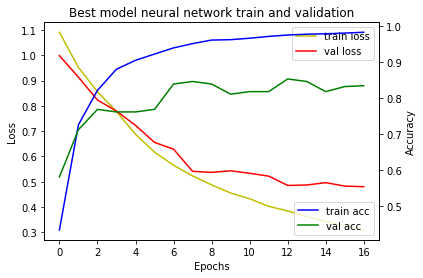

learning rate: 3.0e-06
num_dense_layers: 2
num_dense_nodes: 485

Epoch 1/17
70/70 [==============================] - 44s 633ms/step - loss: 0.9996 - acc: 0.6339 - val_loss: 0.9137 - val_acc: 0.7200
Epoch 2/17
70/70 [==============================] - 44s 627ms/step - loss: 0.7822 - acc: 0.8876 - val_loss: 0.7604 - val_acc: 0.7746
Epoch 3/17
70/70 [==============================] - 43s 617ms/step - loss: 0.6214 - acc: 0.9336 - val_loss: 0.6042 - val_acc: 0.8380
Epoch 4/17
70/70 [==============================] - 44s 624ms/step - loss: 0.5021 - acc: 0.9540 - val_loss: 0.5721 - val_acc: 0.8169
Epoch 5/17
70/70 [==============================] - 44s 625ms/step - loss: 0.4120 - acc: 0.9650 - val_loss: 0.5424 - val_acc: 0.8169
Epoch 6/17
70/70 [==============================] - 44s 625ms/step - loss: 0.3427 - acc: 0.9718 - val_loss: 0.4896 - val_acc: 0.8169
Epoch 7/17
70/70 [==============================] - 44s 622ms/step - loss: 0.2888 - acc: 0.9748 - val_loss: 0.4522 - val_acc: 0.8451
Epoc

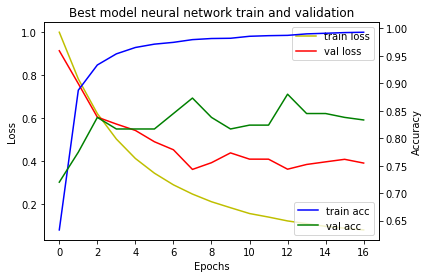

learning rate: 9.2e-07
num_dense_layers: 2
num_dense_nodes: 272

Epoch 1/17
70/70 [==============================] - 45s 639ms/step - loss: 1.1066 - acc: 0.4497 - val_loss: 0.9963 - val_acc: 0.7200
Epoch 2/17
70/70 [==============================] - 43s 619ms/step - loss: 0.9855 - acc: 0.6961 - val_loss: 0.9696 - val_acc: 0.7183
Epoch 3/17
70/70 [==============================] - 43s 618ms/step - loss: 0.9184 - acc: 0.7899 - val_loss: 0.8968 - val_acc: 0.7465
Epoch 4/17
70/70 [==============================] - 43s 618ms/step - loss: 0.8573 - acc: 0.8284 - val_loss: 0.8361 - val_acc: 0.8028
Epoch 5/17
70/70 [==============================] - 43s 619ms/step - loss: 0.8045 - acc: 0.8515 - val_loss: 0.8168 - val_acc: 0.7817
Epoch 6/17
70/70 [==============================] - 43s 619ms/step - loss: 0.7513 - acc: 0.8804 - val_loss: 0.7489 - val_acc: 0.8028
Epoch 7/17
70/70 [==============================] - 43s 618ms/step - loss: 0.7110 - acc: 0.9025 - val_loss: 0.7113 - val_acc: 0.7958
Epoc

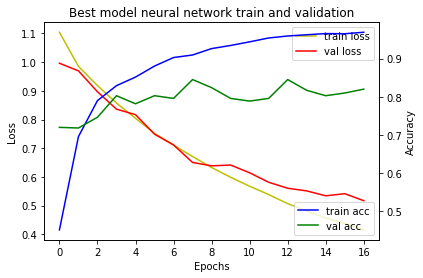

learning rate: 4.6e-03
num_dense_layers: 2
num_dense_nodes: 414

Epoch 1/17
70/70 [==============================] - 44s 630ms/step - loss: 10.6493 - acc: 0.3310 - val_loss: 9.9932 - val_acc: 0.3800
Epoch 2/17
70/70 [==============================] - 43s 618ms/step - loss: 10.7212 - acc: 0.3348 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 3/17
70/70 [==============================] - 43s 619ms/step - loss: 10.7449 - acc: 0.3334 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 4/17
70/70 [==============================] - 43s 619ms/step - loss: 10.7353 - acc: 0.3340 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 5/17
70/70 [==============================] - 43s 619ms/step - loss: 10.7266 - acc: 0.3345 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 6/17
70/70 [==============================] - 44s 624ms/step - loss: 10.7376 - acc: 0.3338 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 7/17
70/70 [==============================] - 43s 613ms/step - loss: 10.7633 - acc: 0.3322 - val_loss: 10.2157 - val_acc

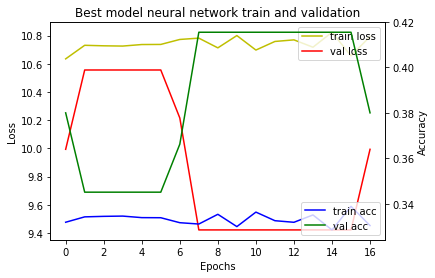

learning rate: 2.1e-03
num_dense_layers: 3
num_dense_nodes: 601

Epoch 1/17
70/70 [==============================] - 45s 636ms/step - loss: 10.6304 - acc: 0.3314 - val_loss: 8.2740 - val_acc: 0.4867
Epoch 2/17
70/70 [==============================] - 44s 623ms/step - loss: 10.7497 - acc: 0.3331 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 3/17
70/70 [==============================] - 44s 625ms/step - loss: 10.7548 - acc: 0.3328 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 4/17
70/70 [==============================] - 44s 625ms/step - loss: 10.6987 - acc: 0.3362 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 5/17
70/70 [==============================] - 44s 624ms/step - loss: 10.7659 - acc: 0.3321 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 6/17
70/70 [==============================] - 44s 624ms/step - loss: 10.7728 - acc: 0.3316 - val_loss: 7.8320 - val_acc: 0.5141
Epoch 7/17
70/70 [==============================] - 44s 624ms/step - loss: 10.7563 - acc: 0.3327 - val_loss: 7.8320 - val_acc: 0.51

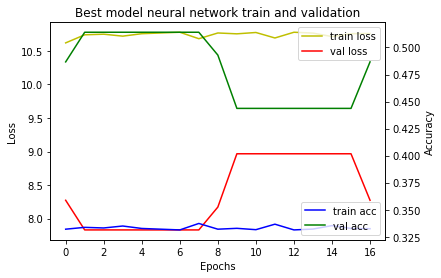

learning rate: 1.9e-04
num_dense_layers: 1
num_dense_nodes: 275

Epoch 1/17
70/70 [==============================] - 44s 630ms/step - loss: 0.4067 - acc: 0.8829 - val_loss: 0.4437 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 43s 620ms/step - loss: 0.0780 - acc: 0.9924 - val_loss: 0.4736 - val_acc: 0.8310
Epoch 3/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0412 - acc: 0.9944 - val_loss: 0.3740 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 43s 620ms/step - loss: 0.0268 - acc: 0.9970 - val_loss: 0.4994 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0185 - acc: 0.9989 - val_loss: 0.5343 - val_acc: 0.8169
Epoch 6/17
70/70 [==============================] - 43s 620ms/step - loss: 0.0136 - acc: 0.9994 - val_loss: 0.5494 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 43s 620ms/step - loss: 0.0104 - acc: 0.9994 - val_loss: 0.4979 - val_acc: 0.8380
Epoc

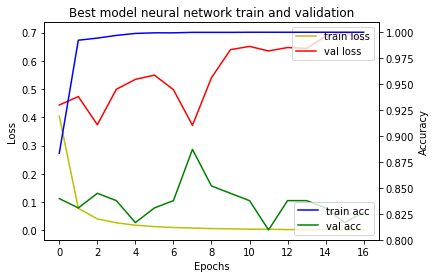

learning rate: 3.3e-05
num_dense_layers: 2
num_dense_nodes: 487

Epoch 1/17
70/70 [==============================] - 44s 634ms/step - loss: 0.5292 - acc: 0.8505 - val_loss: 0.3890 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 44s 622ms/step - loss: 0.1322 - acc: 0.9854 - val_loss: 0.3799 - val_acc: 0.8310
Epoch 3/17
70/70 [==============================] - 44s 623ms/step - loss: 0.0595 - acc: 0.9929 - val_loss: 0.3059 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 44s 624ms/step - loss: 0.0357 - acc: 0.9950 - val_loss: 0.3971 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 44s 623ms/step - loss: 0.0238 - acc: 0.9964 - val_loss: 0.4518 - val_acc: 0.8451
Epoch 6/17
70/70 [==============================] - 44s 623ms/step - loss: 0.0165 - acc: 0.9972 - val_loss: 0.4478 - val_acc: 0.8169
Epoch 7/17
70/70 [==============================] - 44s 629ms/step - loss: 0.0137 - acc: 0.9982 - val_loss: 0.3980 - val_acc: 0.8592
Epoc

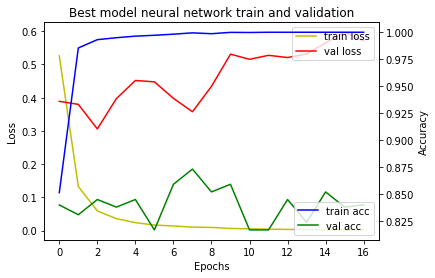

learning rate: 7.4e-04
num_dense_layers: 3
num_dense_nodes: 1008

Epoch 1/17
70/70 [==============================] - 45s 647ms/step - loss: 0.6766 - acc: 0.7697 - val_loss: 0.4359 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 44s 632ms/step - loss: 0.1338 - acc: 0.9591 - val_loss: 0.7424 - val_acc: 0.8169
Epoch 3/17
70/70 [==============================] - 44s 633ms/step - loss: 0.0229 - acc: 0.9921 - val_loss: 0.5400 - val_acc: 0.8380
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0073 - acc: 0.9971 - val_loss: 1.0223 - val_acc: 0.7887
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 1.0502 - val_acc: 0.8239
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 8.2621e-04 - acc: 0.9999 - val_loss: 1.0458 - val_acc: 0.8099
Epoch 7/17
70/70 [==============================] - 44s 632ms/step - loss: 1.9052e-04 - acc: 1.0000 - val_loss: 0.9828 - val_acc: 0.

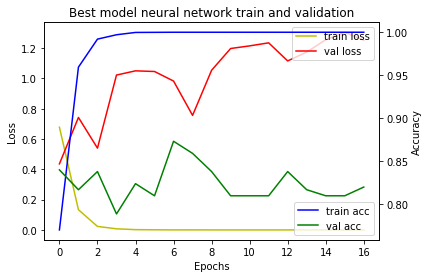

learning rate: 8.3e-07
num_dense_layers: 2
num_dense_nodes: 1022

Epoch 1/17
70/70 [==============================] - 45s 648ms/step - loss: 1.0575 - acc: 0.5518 - val_loss: 1.0022 - val_acc: 0.6933
Epoch 2/17
70/70 [==============================] - 44s 633ms/step - loss: 0.9372 - acc: 0.7970 - val_loss: 0.9026 - val_acc: 0.8028
Epoch 3/17
70/70 [==============================] - 44s 632ms/step - loss: 0.8372 - acc: 0.8556 - val_loss: 0.7928 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 44s 633ms/step - loss: 0.7508 - acc: 0.9089 - val_loss: 0.7437 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 44s 633ms/step - loss: 0.6781 - acc: 0.9210 - val_loss: 0.7148 - val_acc: 0.8099
Epoch 6/17
70/70 [==============================] - 44s 633ms/step - loss: 0.6197 - acc: 0.9423 - val_loss: 0.6490 - val_acc: 0.8239
Epoch 7/17
70/70 [==============================] - 44s 634ms/step - loss: 0.5614 - acc: 0.9474 - val_loss: 0.6368 - val_acc: 0.8310
Epo

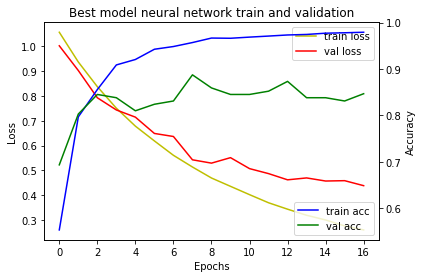

learning rate: 6.3e-06
num_dense_layers: 2
num_dense_nodes: 26

Epoch 1/17
70/70 [==============================] - 44s 628ms/step - loss: 1.0617 - acc: 0.4513 - val_loss: 1.0224 - val_acc: 0.3800
Epoch 2/17
70/70 [==============================] - 43s 618ms/step - loss: 0.9339 - acc: 0.6170 - val_loss: 0.9297 - val_acc: 0.4366
Epoch 3/17
70/70 [==============================] - 43s 618ms/step - loss: 0.8347 - acc: 0.7345 - val_loss: 0.8182 - val_acc: 0.5845
Epoch 4/17
70/70 [==============================] - 43s 619ms/step - loss: 0.7519 - acc: 0.8611 - val_loss: 0.7488 - val_acc: 0.7958
Epoch 5/17
70/70 [==============================] - 43s 618ms/step - loss: 0.6822 - acc: 0.9186 - val_loss: 0.7033 - val_acc: 0.8310
Epoch 6/17
70/70 [==============================] - 43s 619ms/step - loss: 0.6214 - acc: 0.9444 - val_loss: 0.6477 - val_acc: 0.8169
Epoch 7/17
70/70 [==============================] - 43s 618ms/step - loss: 0.5736 - acc: 0.9511 - val_loss: 0.6003 - val_acc: 0.8592
Epoch

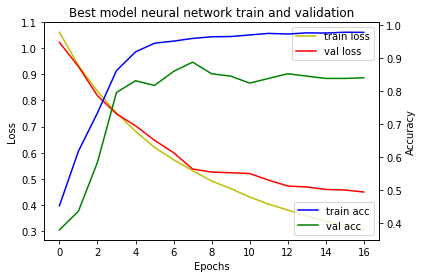

learning rate: 5.2e-05
num_dense_layers: 2
num_dense_nodes: 195

Epoch 1/17
70/70 [==============================] - 44s 628ms/step - loss: 0.5518 - acc: 0.8310 - val_loss: 0.4304 - val_acc: 0.8467
Epoch 2/17
70/70 [==============================] - 43s 617ms/step - loss: 0.1572 - acc: 0.9825 - val_loss: 0.3773 - val_acc: 0.8169
Epoch 3/17
70/70 [==============================] - 43s 617ms/step - loss: 0.0709 - acc: 0.9926 - val_loss: 0.3014 - val_acc: 0.8310
Epoch 4/17
70/70 [==============================] - 43s 618ms/step - loss: 0.0416 - acc: 0.9948 - val_loss: 0.3955 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 43s 618ms/step - loss: 0.0287 - acc: 0.9955 - val_loss: 0.4161 - val_acc: 0.8169
Epoch 6/17
70/70 [==============================] - 43s 618ms/step - loss: 0.0207 - acc: 0.9968 - val_loss: 0.4299 - val_acc: 0.8169
Epoch 7/17
70/70 [==============================] - 43s 617ms/step - loss: 0.0157 - acc: 0.9979 - val_loss: 0.4021 - val_acc: 0.8239
Epoc

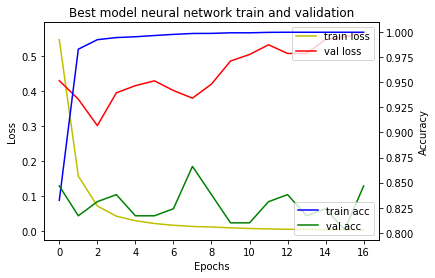

learning rate: 1.0e-07
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 644ms/step - loss: 1.1105 - acc: 0.3250 - val_loss: 1.1091 - val_acc: 0.2533
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 1.0907 - acc: 0.3637 - val_loss: 1.0861 - val_acc: 0.4085
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 1.0738 - acc: 0.4605 - val_loss: 1.0686 - val_acc: 0.5070
Epoch 4/17
70/70 [==============================] - 44s 632ms/step - loss: 1.0568 - acc: 0.5830 - val_loss: 1.0531 - val_acc: 0.5423
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 1.0407 - acc: 0.6689 - val_loss: 1.0419 - val_acc: 0.5915
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 1.0246 - acc: 0.7286 - val_loss: 1.0156 - val_acc: 0.6690
Epoch 7/17
70/70 [==============================] - 45s 637ms/step - loss: 1.0087 - acc: 0.7590 - val_loss: 1.0015 - val_acc: 0.6761
Epo

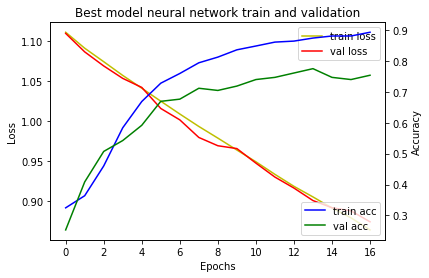

learning rate: 4.1e-04
num_dense_layers: 2
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 644ms/step - loss: 0.6575 - acc: 0.8058 - val_loss: 0.3288 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0381 - acc: 0.9932 - val_loss: 0.4118 - val_acc: 0.8592
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0154 - acc: 0.9963 - val_loss: 0.3042 - val_acc: 0.8662
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0093 - acc: 0.9977 - val_loss: 0.4768 - val_acc: 0.8099
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.5225 - val_acc: 0.8239
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.5865 - val_acc: 0.8380
Epoch 7/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0015 - acc: 0.9999 - val_loss: 0.4941 - val_acc: 0.8310
Epo

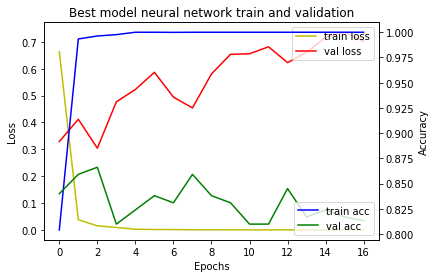

learning rate: 3.9e-07
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 642ms/step - loss: 1.2311 - acc: 0.3462 - val_loss: 1.1339 - val_acc: 0.2000
Epoch 2/17
70/70 [==============================] - 44s 629ms/step - loss: 1.0538 - acc: 0.5021 - val_loss: 1.0329 - val_acc: 0.4648
Epoch 3/17
70/70 [==============================] - 44s 630ms/step - loss: 0.9824 - acc: 0.6516 - val_loss: 0.9649 - val_acc: 0.5634
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.9174 - acc: 0.7463 - val_loss: 0.9163 - val_acc: 0.6408
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.8595 - acc: 0.8024 - val_loss: 0.8708 - val_acc: 0.6901
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.8083 - acc: 0.8503 - val_loss: 0.8068 - val_acc: 0.7465
Epoch 7/17
70/70 [==============================] - 44s 630ms/step - loss: 0.7638 - acc: 0.8703 - val_loss: 0.7874 - val_acc: 0.7324
Epo

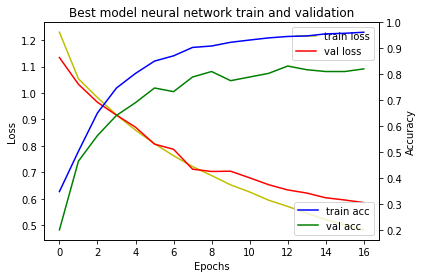

learning rate: 8.9e-05
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 647ms/step - loss: 0.3085 - acc: 0.8904 - val_loss: 0.3743 - val_acc: 0.8533
Epoch 2/17
70/70 [==============================] - 44s 634ms/step - loss: 0.0254 - acc: 0.9930 - val_loss: 0.4631 - val_acc: 0.8310
Epoch 3/17
70/70 [==============================] - 44s 635ms/step - loss: 0.0110 - acc: 0.9973 - val_loss: 0.3311 - val_acc: 0.8592
Epoch 4/17
70/70 [==============================] - 44s 634ms/step - loss: 0.0053 - acc: 0.9991 - val_loss: 0.6043 - val_acc: 0.8451
Epoch 5/17
70/70 [==============================] - 44s 634ms/step - loss: 0.0045 - acc: 0.9992 - val_loss: 0.6631 - val_acc: 0.8803
Epoch 6/17
70/70 [==============================] - 44s 635ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.6797 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 44s 634ms/step - loss: 4.8259e-04 - acc: 1.0000 - val_loss: 0.5921 - val_acc: 0.8592

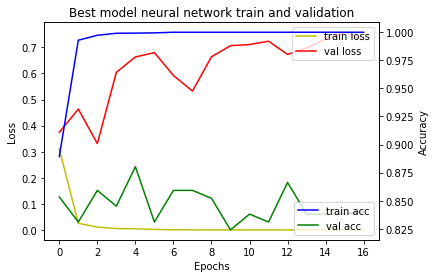

learning rate: 1.9e-05
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 646ms/step - loss: 0.5251 - acc: 0.8784 - val_loss: 0.3796 - val_acc: 0.8600
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 0.1142 - acc: 0.9860 - val_loss: 0.3784 - val_acc: 0.8310
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0409 - acc: 0.9945 - val_loss: 0.2851 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0241 - acc: 0.9961 - val_loss: 0.3937 - val_acc: 0.8310
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0148 - acc: 0.9974 - val_loss: 0.4348 - val_acc: 0.8169
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0093 - acc: 0.9987 - val_loss: 0.4565 - val_acc: 0.8099
Epoch 7/17
70/70 [==============================] - 44s 632ms/step - loss: 0.0077 - acc: 0.9992 - val_loss: 0.4132 - val_acc: 0.8310
Epo

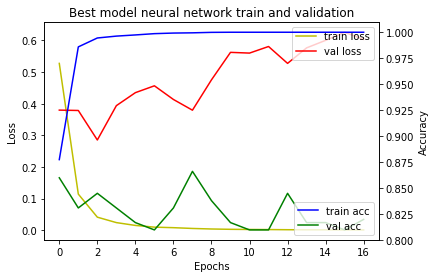

learning rate: 1.0e-07
num_dense_layers: 3
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 44s 628ms/step - loss: 1.1001 - acc: 0.3322 - val_loss: 1.0923 - val_acc: 0.4133
Epoch 2/17
70/70 [==============================] - 43s 617ms/step - loss: 1.0997 - acc: 0.3351 - val_loss: 1.0947 - val_acc: 0.3873
Epoch 3/17
70/70 [==============================] - 43s 617ms/step - loss: 1.0996 - acc: 0.3178 - val_loss: 1.0941 - val_acc: 0.3873
Epoch 4/17
70/70 [==============================] - 44s 626ms/step - loss: 1.0990 - acc: 0.3225 - val_loss: 1.0953 - val_acc: 0.3873
Epoch 5/17
70/70 [==============================] - 45s 650ms/step - loss: 1.0991 - acc: 0.3208 - val_loss: 1.0943 - val_acc: 0.3873
Epoch 6/17
70/70 [==============================] - 44s 622ms/step - loss: 1.0986 - acc: 0.3261 - val_loss: 1.0938 - val_acc: 0.3944
Epoch 7/17
70/70 [==============================] - 45s 643ms/step - loss: 1.0983 - acc: 0.3344 - val_loss: 1.0928 - val_acc: 0.4225
Epoch 

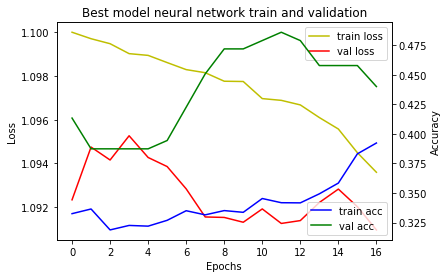

learning rate: 4.9e-06
num_dense_layers: 1
num_dense_nodes: 244

Epoch 1/17
70/70 [==============================] - 48s 687ms/step - loss: 0.9407 - acc: 0.6253 - val_loss: 0.7711 - val_acc: 0.8533
Epoch 2/17
70/70 [==============================] - 45s 647ms/step - loss: 0.6734 - acc: 0.8571 - val_loss: 0.6532 - val_acc: 0.8310
Epoch 3/17
70/70 [==============================] - 47s 672ms/step - loss: 0.5253 - acc: 0.9330 - val_loss: 0.5213 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 46s 661ms/step - loss: 0.4275 - acc: 0.9580 - val_loss: 0.5277 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 46s 651ms/step - loss: 0.3593 - acc: 0.9700 - val_loss: 0.5066 - val_acc: 0.8239
Epoch 6/17
70/70 [==============================] - 46s 660ms/step - loss: 0.3043 - acc: 0.9764 - val_loss: 0.4594 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 46s 662ms/step - loss: 0.2686 - acc: 0.9773 - val_loss: 0.4444 - val_acc: 0.8380
Epoc

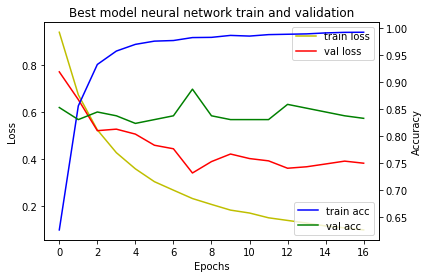

learning rate: 8.8e-05
num_dense_layers: 3
num_dense_nodes: 555

Epoch 1/17
70/70 [==============================] - 48s 688ms/step - loss: 0.3370 - acc: 0.8989 - val_loss: 0.3790 - val_acc: 0.8267
Epoch 2/17
70/70 [==============================] - 47s 669ms/step - loss: 0.0297 - acc: 0.9939 - val_loss: 0.4636 - val_acc: 0.8239
Epoch 3/17
70/70 [==============================] - 46s 663ms/step - loss: 0.0138 - acc: 0.9970 - val_loss: 0.3331 - val_acc: 0.8521
Epoch 4/17
70/70 [==============================] - 48s 681ms/step - loss: 0.0107 - acc: 0.9970 - val_loss: 0.6000 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 45s 642ms/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.5511 - val_acc: 0.8239
Epoch 6/17
70/70 [==============================] - 45s 639ms/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.5743 - val_acc: 0.8028
Epoch 7/17
70/70 [==============================] - 46s 650ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5511 - val_acc: 0.8662
Epoc

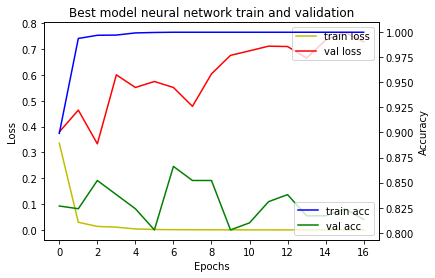

learning rate: 1.3e-04
num_dense_layers: 3
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 47s 678ms/step - loss: 1.0029 - acc: 0.3324 - val_loss: 1.0701 - val_acc: 0.1333
Epoch 2/17
70/70 [==============================] - 46s 659ms/step - loss: 0.9121 - acc: 0.3334 - val_loss: 1.0621 - val_acc: 0.1408
Epoch 3/17
70/70 [==============================] - 46s 661ms/step - loss: 0.8756 - acc: 0.3312 - val_loss: 1.0515 - val_acc: 0.1338
Epoch 4/17
70/70 [==============================] - 47s 676ms/step - loss: 0.8493 - acc: 0.3558 - val_loss: 1.0578 - val_acc: 0.1690
Epoch 5/17
70/70 [==============================] - 47s 670ms/step - loss: 0.8293 - acc: 0.6700 - val_loss: 1.0222 - val_acc: 0.5775
Epoch 6/17
70/70 [==============================] - 46s 658ms/step - loss: 0.8045 - acc: 0.7507 - val_loss: 1.0173 - val_acc: 0.6408
Epoch 7/17
70/70 [==============================] - 46s 661ms/step - loss: 0.7744 - acc: 0.7798 - val_loss: 1.0283 - val_acc: 0.6408
Epoch 

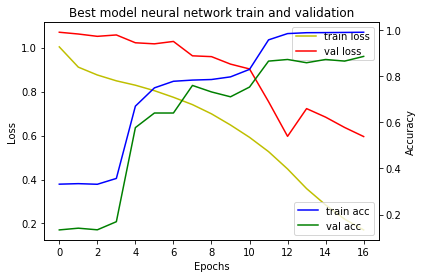

learning rate: 8.2e-05
num_dense_layers: 1
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 47s 670ms/step - loss: 0.8747 - acc: 0.6563 - val_loss: 0.6740 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 45s 638ms/step - loss: 0.5770 - acc: 0.8860 - val_loss: 0.5748 - val_acc: 0.8521
Epoch 3/17
70/70 [==============================] - 47s 674ms/step - loss: 0.4240 - acc: 0.9553 - val_loss: 0.4629 - val_acc: 0.8592
Epoch 4/17
70/70 [==============================] - 48s 685ms/step - loss: 0.3323 - acc: 0.9700 - val_loss: 0.4117 - val_acc: 0.8592
Epoch 5/17
70/70 [==============================] - 47s 670ms/step - loss: 0.2679 - acc: 0.9756 - val_loss: 0.4106 - val_acc: 0.8380
Epoch 6/17
70/70 [==============================] - 46s 653ms/step - loss: 0.2216 - acc: 0.9800 - val_loss: 0.3878 - val_acc: 0.8239
Epoch 7/17
70/70 [==============================] - 47s 667ms/step - loss: 0.1899 - acc: 0.9820 - val_loss: 0.3530 - val_acc: 0.8732
Epoch 

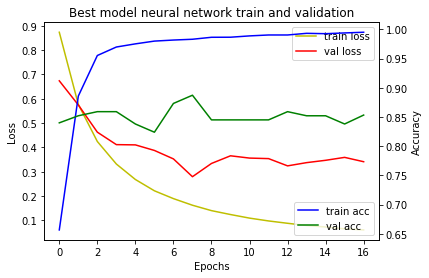

learning rate: 2.6e-04
num_dense_layers: 3
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 47s 668ms/step - loss: 0.9787 - acc: 0.5711 - val_loss: 0.9222 - val_acc: 0.5800
Epoch 2/17
70/70 [==============================] - 47s 674ms/step - loss: 0.7161 - acc: 0.8216 - val_loss: 0.8753 - val_acc: 0.7042
Epoch 3/17
70/70 [==============================] - 46s 662ms/step - loss: 0.5648 - acc: 0.9054 - val_loss: 0.8022 - val_acc: 0.7394
Epoch 4/17
70/70 [==============================] - 46s 651ms/step - loss: 0.4747 - acc: 0.9357 - val_loss: 0.8228 - val_acc: 0.7676
Epoch 5/17
70/70 [==============================] - 45s 641ms/step - loss: 0.4131 - acc: 0.9588 - val_loss: 0.8207 - val_acc: 0.7746
Epoch 6/17
70/70 [==============================] - 46s 654ms/step - loss: 0.3686 - acc: 0.9757 - val_loss: 0.7834 - val_acc: 0.8028
Epoch 7/17
70/70 [==============================] - 46s 661ms/step - loss: 0.3397 - acc: 0.9826 - val_loss: 0.7732 - val_acc: 0.8099
Epoch 

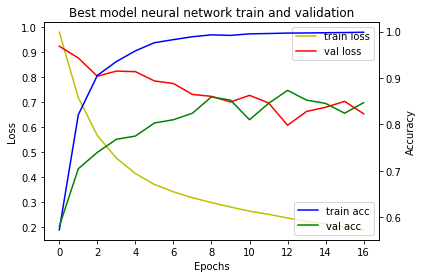

learning rate: 3.0e-06
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 48s 679ms/step - loss: 0.9038 - acc: 0.7714 - val_loss: 0.7616 - val_acc: 0.8067
Epoch 2/17
70/70 [==============================] - 47s 668ms/step - loss: 0.5954 - acc: 0.9254 - val_loss: 0.6031 - val_acc: 0.8169
Epoch 3/17
70/70 [==============================] - 47s 669ms/step - loss: 0.4041 - acc: 0.9617 - val_loss: 0.4709 - val_acc: 0.8592
Epoch 4/17
70/70 [==============================] - 47s 678ms/step - loss: 0.2825 - acc: 0.9760 - val_loss: 0.4481 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 45s 637ms/step - loss: 0.1992 - acc: 0.9835 - val_loss: 0.4334 - val_acc: 0.8380
Epoch 6/17
70/70 [==============================] - 45s 639ms/step - loss: 0.1475 - acc: 0.9868 - val_loss: 0.3873 - val_acc: 0.8451
Epoch 7/17
70/70 [==============================] - 45s 640ms/step - loss: 0.1093 - acc: 0.9905 - val_loss: 0.3595 - val_acc: 0.8592
Epo

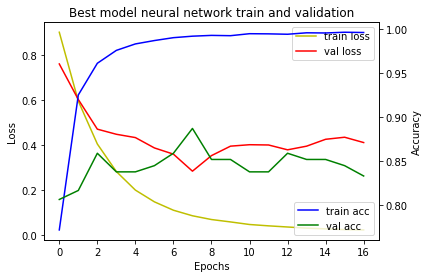

learning rate: 7.8e-07
num_dense_layers: 3
num_dense_nodes: 702

Epoch 1/17
70/70 [==============================] - 45s 645ms/step - loss: 1.0623 - acc: 0.5185 - val_loss: 1.0505 - val_acc: 0.5267
Epoch 2/17
70/70 [==============================] - 44s 633ms/step - loss: 0.9771 - acc: 0.7201 - val_loss: 0.9841 - val_acc: 0.5775
Epoch 3/17
70/70 [==============================] - 46s 653ms/step - loss: 0.8948 - acc: 0.7845 - val_loss: 0.8940 - val_acc: 0.7183
Epoch 4/17
70/70 [==============================] - 45s 636ms/step - loss: 0.8212 - acc: 0.8402 - val_loss: 0.8359 - val_acc: 0.7535
Epoch 5/17
70/70 [==============================] - 44s 635ms/step - loss: 0.7517 - acc: 0.8937 - val_loss: 0.7997 - val_acc: 0.7324
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.6877 - acc: 0.9137 - val_loss: 0.7077 - val_acc: 0.7817
Epoch 7/17
70/70 [==============================] - 44s 634ms/step - loss: 0.6298 - acc: 0.9223 - val_loss: 0.6645 - val_acc: 0.8028
Epoc

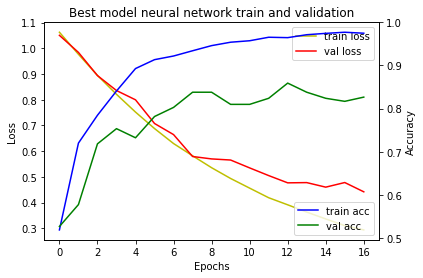

learning rate: 1.0e-02
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 648ms/step - loss: 10.5908 - acc: 0.3352 - val_loss: 9.9932 - val_acc: 0.3800
Epoch 2/17
70/70 [==============================] - 44s 636ms/step - loss: 10.6909 - acc: 0.3367 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 3/17
70/70 [==============================] - 44s 635ms/step - loss: 10.7542 - acc: 0.3328 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 4/17
70/70 [==============================] - 45s 637ms/step - loss: 10.7269 - acc: 0.3345 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 5/17
70/70 [==============================] - 45s 636ms/step - loss: 10.7629 - acc: 0.3322 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 6/17
70/70 [==============================] - 44s 634ms/step - loss: 10.7677 - acc: 0.3319 - val_loss: 10.5562 - val_acc: 0.3451
Epoch 7/17
70/70 [==============================] - 44s 636ms/step - loss: 10.7443 - acc: 0.3334 - val_loss: 10.2157 - val_ac

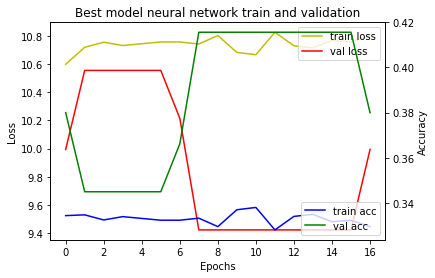

learning rate: 2.2e-06
num_dense_layers: 3
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 45s 641ms/step - loss: 1.0931 - acc: 0.3538 - val_loss: 1.0865 - val_acc: 0.2933
Epoch 2/17
70/70 [==============================] - 45s 637ms/step - loss: 1.0674 - acc: 0.4225 - val_loss: 1.0460 - val_acc: 0.4648
Epoch 3/17
70/70 [==============================] - 45s 643ms/step - loss: 1.0387 - acc: 0.4601 - val_loss: 1.0161 - val_acc: 0.5211
Epoch 4/17
70/70 [==============================] - 44s 624ms/step - loss: 1.0135 - acc: 0.4861 - val_loss: 0.9903 - val_acc: 0.5352
Epoch 5/17
70/70 [==============================] - 44s 626ms/step - loss: 0.9939 - acc: 0.4972 - val_loss: 0.9751 - val_acc: 0.5423
Epoch 6/17
70/70 [==============================] - 44s 633ms/step - loss: 0.9759 - acc: 0.5091 - val_loss: 0.9580 - val_acc: 0.5423
Epoch 7/17
70/70 [==============================] - 44s 624ms/step - loss: 0.9594 - acc: 0.5226 - val_loss: 0.9568 - val_acc: 0.5211
Epoch 

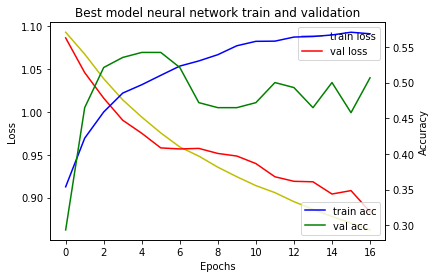

learning rate: 1.6e-07
num_dense_layers: 1
num_dense_nodes: 432

Epoch 1/17
70/70 [==============================] - 45s 637ms/step - loss: 1.1451 - acc: 0.3680 - val_loss: 1.0356 - val_acc: 0.5400
Epoch 2/17
70/70 [==============================] - 45s 640ms/step - loss: 1.0851 - acc: 0.4200 - val_loss: 1.0551 - val_acc: 0.5634
Epoch 3/17
70/70 [==============================] - 44s 632ms/step - loss: 1.0544 - acc: 0.4977 - val_loss: 1.0437 - val_acc: 0.5493
Epoch 4/17
70/70 [==============================] - 44s 627ms/step - loss: 1.0317 - acc: 0.5522 - val_loss: 1.0360 - val_acc: 0.5563
Epoch 5/17
70/70 [==============================] - 44s 629ms/step - loss: 1.0094 - acc: 0.6013 - val_loss: 1.0213 - val_acc: 0.5563
Epoch 6/17
70/70 [==============================] - 44s 629ms/step - loss: 0.9872 - acc: 0.6407 - val_loss: 0.9958 - val_acc: 0.5775
Epoch 7/17
70/70 [==============================] - 44s 633ms/step - loss: 0.9668 - acc: 0.6729 - val_loss: 0.9793 - val_acc: 0.5986
Epoc

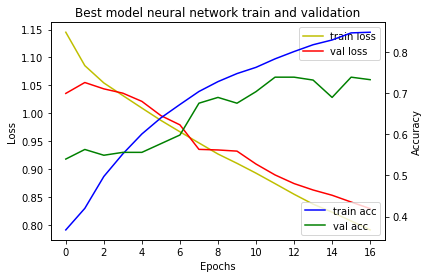

learning rate: 2.2e-06
num_dense_layers: 1
num_dense_nodes: 737

Epoch 1/17
70/70 [==============================] - 45s 643ms/step - loss: 1.0270 - acc: 0.5958 - val_loss: 0.8826 - val_acc: 0.7267
Epoch 2/17
70/70 [==============================] - 45s 645ms/step - loss: 0.7478 - acc: 0.8869 - val_loss: 0.7205 - val_acc: 0.8099
Epoch 3/17
70/70 [==============================] - 45s 638ms/step - loss: 0.6002 - acc: 0.9353 - val_loss: 0.6255 - val_acc: 0.8169
Epoch 4/17
70/70 [==============================] - 44s 634ms/step - loss: 0.4993 - acc: 0.9527 - val_loss: 0.5942 - val_acc: 0.7887
Epoch 5/17
70/70 [==============================] - 45s 640ms/step - loss: 0.4241 - acc: 0.9623 - val_loss: 0.5372 - val_acc: 0.8239
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.3664 - acc: 0.9722 - val_loss: 0.5086 - val_acc: 0.8239
Epoch 7/17
70/70 [==============================] - 45s 636ms/step - loss: 0.3200 - acc: 0.9766 - val_loss: 0.4719 - val_acc: 0.8592
Epoc

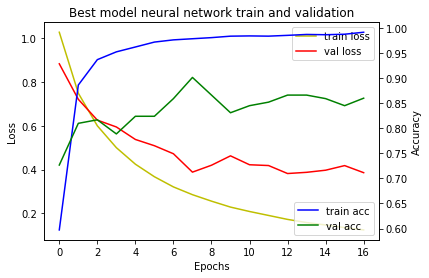

learning rate: 5.5e-05
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 647ms/step - loss: 0.4152 - acc: 0.8565 - val_loss: 0.3795 - val_acc: 0.8333
Epoch 2/17
70/70 [==============================] - 44s 633ms/step - loss: 0.0965 - acc: 0.9906 - val_loss: 0.3812 - val_acc: 0.8380
Epoch 3/17
70/70 [==============================] - 44s 634ms/step - loss: 0.0517 - acc: 0.9955 - val_loss: 0.2867 - val_acc: 0.8521
Epoch 4/17
70/70 [==============================] - 44s 634ms/step - loss: 0.0347 - acc: 0.9953 - val_loss: 0.3924 - val_acc: 0.8521
Epoch 5/17
70/70 [==============================] - 44s 633ms/step - loss: 0.0247 - acc: 0.9972 - val_loss: 0.4477 - val_acc: 0.8451
Epoch 6/17
70/70 [==============================] - 44s 633ms/step - loss: 0.0190 - acc: 0.9983 - val_loss: 0.4399 - val_acc: 0.8380
Epoch 7/17
70/70 [==============================] - 45s 638ms/step - loss: 0.0143 - acc: 0.9989 - val_loss: 0.3951 - val_acc: 0.8521
Epo

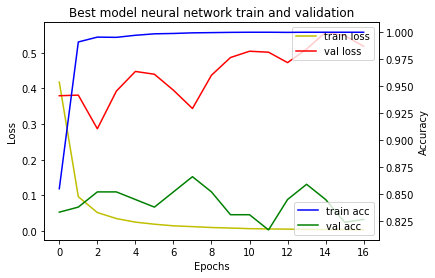

learning rate: 4.4e-05
num_dense_layers: 1
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 45s 641ms/step - loss: 1.1008 - acc: 0.3311 - val_loss: 1.0986 - val_acc: 0.3800
Epoch 2/17
70/70 [==============================] - 44s 632ms/step - loss: 1.0986 - acc: 0.3332 - val_loss: 1.0986 - val_acc: 0.3451
Epoch 3/17
70/70 [==============================] - 45s 641ms/step - loss: 1.0986 - acc: 0.3334 - val_loss: 1.0986 - val_acc: 0.3451
Epoch 4/17
70/70 [==============================] - 44s 625ms/step - loss: 1.0986 - acc: 0.3266 - val_loss: 1.0985 - val_acc: 0.5141
Epoch 5/17
70/70 [==============================] - 44s 626ms/step - loss: 1.0986 - acc: 0.3323 - val_loss: 1.0986 - val_acc: 0.3451
Epoch 6/17
70/70 [==============================] - 44s 626ms/step - loss: 1.0986 - acc: 0.3325 - val_loss: 1.0986 - val_acc: 0.3451
Epoch 7/17
70/70 [==============================] - 44s 632ms/step - loss: 1.0986 - acc: 0.3256 - val_loss: 1.0985 - val_acc: 0.3662
Epoch 

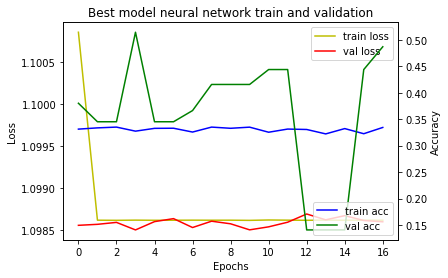

learning rate: 5.5e-06
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 648ms/step - loss: 0.8013 - acc: 0.7361 - val_loss: 0.5997 - val_acc: 0.8467
Epoch 2/17
70/70 [==============================] - 44s 635ms/step - loss: 0.4546 - acc: 0.9492 - val_loss: 0.5326 - val_acc: 0.8380
Epoch 3/17
70/70 [==============================] - 46s 651ms/step - loss: 0.3108 - acc: 0.9761 - val_loss: 0.4082 - val_acc: 0.8592
Epoch 4/17
70/70 [==============================] - 45s 640ms/step - loss: 0.2326 - acc: 0.9822 - val_loss: 0.3934 - val_acc: 0.8451
Epoch 5/17
70/70 [==============================] - 45s 647ms/step - loss: 0.1797 - acc: 0.9869 - val_loss: 0.4319 - val_acc: 0.8451
Epoch 6/17
70/70 [==============================] - 45s 646ms/step - loss: 0.1460 - acc: 0.9896 - val_loss: 0.3960 - val_acc: 0.8380
Epoch 7/17
70/70 [==============================] - 44s 635ms/step - loss: 0.1212 - acc: 0.9919 - val_loss: 0.3768 - val_acc: 0.8592
Epo

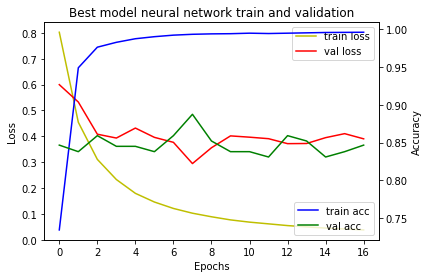

learning rate: 1.7e-04
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 46s 651ms/step - loss: 0.3794 - acc: 0.8578 - val_loss: 0.4325 - val_acc: 0.8667
Epoch 2/17
70/70 [==============================] - 44s 635ms/step - loss: 0.0264 - acc: 0.9933 - val_loss: 0.6225 - val_acc: 0.7887
Epoch 3/17
70/70 [==============================] - 44s 635ms/step - loss: 0.0112 - acc: 0.9968 - val_loss: 0.5086 - val_acc: 0.8944
Epoch 4/17
70/70 [==============================] - 45s 639ms/step - loss: 0.0067 - acc: 0.9984 - val_loss: 0.5834 - val_acc: 0.8310
Epoch 5/17
70/70 [==============================] - 44s 629ms/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.6331 - val_acc: 0.8310
Epoch 6/17
70/70 [==============================] - 44s 634ms/step - loss: 9.8347e-04 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 44s 634ms/step - loss: 4.0345e-04 - acc: 1.0000 - val_loss: 0.5855 - val_acc: 0.

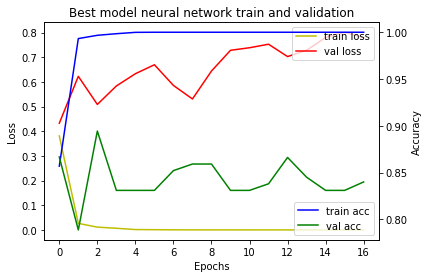

learning rate: 1.9e-06
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 642ms/step - loss: 0.9907 - acc: 0.6087 - val_loss: 0.8462 - val_acc: 0.7533
Epoch 2/17
70/70 [==============================] - 44s 630ms/step - loss: 0.7218 - acc: 0.8926 - val_loss: 0.7132 - val_acc: 0.7958
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.5667 - acc: 0.9400 - val_loss: 0.5764 - val_acc: 0.8732
Epoch 4/17
70/70 [==============================] - 44s 630ms/step - loss: 0.4683 - acc: 0.9597 - val_loss: 0.5466 - val_acc: 0.8592
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.3943 - acc: 0.9710 - val_loss: 0.5263 - val_acc: 0.8451
Epoch 6/17
70/70 [==============================] - 44s 630ms/step - loss: 0.3428 - acc: 0.9750 - val_loss: 0.4922 - val_acc: 0.8380
Epoch 7/17
70/70 [==============================] - 44s 631ms/step - loss: 0.3002 - acc: 0.9772 - val_loss: 0.4557 - val_acc: 0.8521
Epo

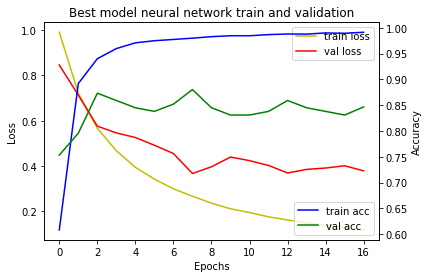

learning rate: 6.9e-06
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 642ms/step - loss: 0.7176 - acc: 0.8027 - val_loss: 0.5979 - val_acc: 0.7600
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 0.3626 - acc: 0.9674 - val_loss: 0.5013 - val_acc: 0.8239
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.2356 - acc: 0.9819 - val_loss: 0.3971 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.1726 - acc: 0.9861 - val_loss: 0.3983 - val_acc: 0.8521
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.1305 - acc: 0.9898 - val_loss: 0.4176 - val_acc: 0.8310
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.1051 - acc: 0.9914 - val_loss: 0.4062 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0856 - acc: 0.9943 - val_loss: 0.3694 - val_acc: 0.8662
Epo

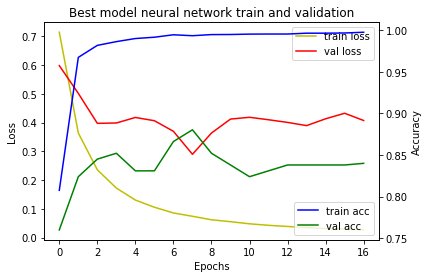

learning rate: 1.3e-06
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 644ms/step - loss: 0.9914 - acc: 0.6147 - val_loss: 0.8975 - val_acc: 0.7200
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 0.7906 - acc: 0.8445 - val_loss: 0.7732 - val_acc: 0.7606
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.6631 - acc: 0.9092 - val_loss: 0.6762 - val_acc: 0.8099
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.5687 - acc: 0.9403 - val_loss: 0.6132 - val_acc: 0.8169
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.4955 - acc: 0.9546 - val_loss: 0.6083 - val_acc: 0.8028
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.4415 - acc: 0.9658 - val_loss: 0.5172 - val_acc: 0.7958
Epoch 7/17
70/70 [==============================] - 44s 631ms/step - loss: 0.3919 - acc: 0.9683 - val_loss: 0.5008 - val_acc: 0.8169
Epo

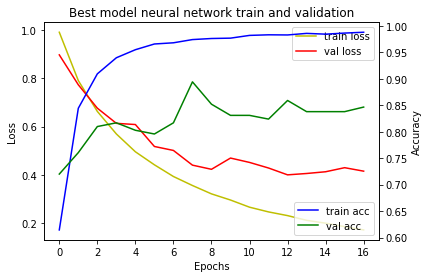

learning rate: 1.7e-04
num_dense_layers: 3
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 644ms/step - loss: 0.3569 - acc: 0.8745 - val_loss: 0.4025 - val_acc: 0.8400
Epoch 2/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0280 - acc: 0.9929 - val_loss: 0.5429 - val_acc: 0.8732
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0792 - acc: 0.9712 - val_loss: 0.3917 - val_acc: 0.8521
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0061 - acc: 0.9982 - val_loss: 0.6139 - val_acc: 0.8451
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0061 - acc: 0.9984 - val_loss: 0.6474 - val_acc: 0.8380
Epoch 6/17
70/70 [==============================] - 44s 631ms/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.6679 - val_acc: 0.8380
Epoch 7/17
70/70 [==============================] - 44s 631ms/step - loss: 4.9582e-04 - acc: 1.0000 - val_loss: 0.6083 - val_acc: 0.8521

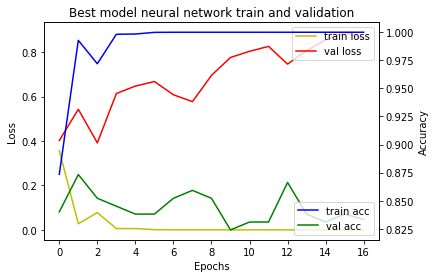

learning rate: 1.1e-04
num_dense_layers: 2
num_dense_nodes: 5

Epoch 1/17
70/70 [==============================] - 44s 626ms/step - loss: 0.9914 - acc: 0.5201 - val_loss: 0.8754 - val_acc: 0.5067
Epoch 2/17
70/70 [==============================] - 43s 617ms/step - loss: 0.7710 - acc: 0.6515 - val_loss: 0.7472 - val_acc: 0.5493
Epoch 3/17
70/70 [==============================] - 43s 618ms/step - loss: 0.6546 - acc: 0.6592 - val_loss: 0.6402 - val_acc: 0.5282
Epoch 4/17
70/70 [==============================] - 43s 618ms/step - loss: 0.5737 - acc: 0.6620 - val_loss: 0.5704 - val_acc: 0.5423
Epoch 5/17
70/70 [==============================] - 43s 617ms/step - loss: 0.5126 - acc: 0.7516 - val_loss: 0.5155 - val_acc: 0.7042
Epoch 6/17
70/70 [==============================] - 43s 618ms/step - loss: 0.4655 - acc: 0.8833 - val_loss: 0.4683 - val_acc: 0.8169
Epoch 7/17
70/70 [==============================] - 43s 617ms/step - loss: 0.4255 - acc: 0.9308 - val_loss: 0.4276 - val_acc: 0.8592
Epoch 

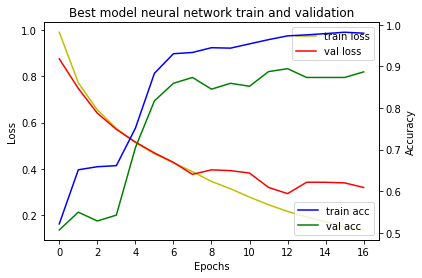

learning rate: 8.4e-05
num_dense_layers: 2
num_dense_nodes: 229

Epoch 1/17
70/70 [==============================] - 44s 628ms/step - loss: 0.5056 - acc: 0.8409 - val_loss: 0.4271 - val_acc: 0.8333
Epoch 2/17
70/70 [==============================] - 43s 618ms/step - loss: 0.1129 - acc: 0.9887 - val_loss: 0.4032 - val_acc: 0.8380
Epoch 3/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0491 - acc: 0.9934 - val_loss: 0.3139 - val_acc: 0.8662
Epoch 4/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0268 - acc: 0.9954 - val_loss: 0.4243 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0188 - acc: 0.9974 - val_loss: 0.4566 - val_acc: 0.8169
Epoch 6/17
70/70 [==============================] - 43s 619ms/step - loss: 0.0132 - acc: 0.9979 - val_loss: 0.4856 - val_acc: 0.8310
Epoch 7/17
70/70 [==============================] - 43s 618ms/step - loss: 0.0096 - acc: 0.9989 - val_loss: 0.4272 - val_acc: 0.8380
Epoc

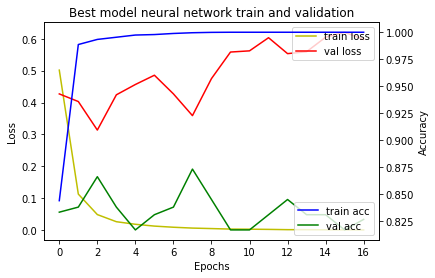

learning rate: 1.5e-04
num_dense_layers: 1
num_dense_nodes: 15

Epoch 1/17
70/70 [==============================] - 44s 626ms/step - loss: 0.9515 - acc: 0.5459 - val_loss: 0.9001 - val_acc: 0.5000
Epoch 2/17
70/70 [==============================] - 43s 617ms/step - loss: 0.7403 - acc: 0.6663 - val_loss: 0.8292 - val_acc: 0.5352
Epoch 3/17
70/70 [==============================] - 43s 617ms/step - loss: 0.6348 - acc: 0.7182 - val_loss: 0.7851 - val_acc: 0.6197
Epoch 4/17
70/70 [==============================] - 43s 618ms/step - loss: 0.5660 - acc: 0.7577 - val_loss: 0.7617 - val_acc: 0.6620
Epoch 5/17
70/70 [==============================] - 43s 617ms/step - loss: 0.5209 - acc: 0.7994 - val_loss: 0.7579 - val_acc: 0.6690
Epoch 6/17
70/70 [==============================] - 43s 617ms/step - loss: 0.4816 - acc: 0.8372 - val_loss: 0.7471 - val_acc: 0.7324
Epoch 7/17
70/70 [==============================] - 43s 617ms/step - loss: 0.4533 - acc: 0.8692 - val_loss: 0.7181 - val_acc: 0.7324
Epoch

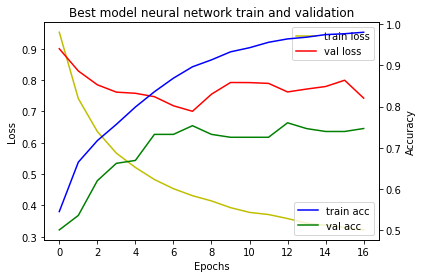

learning rate: 1.2e-06
num_dense_layers: 1
num_dense_nodes: 1024

Epoch 1/17
70/70 [==============================] - 45s 642ms/step - loss: 1.0432 - acc: 0.5293 - val_loss: 0.9252 - val_acc: 0.7400
Epoch 2/17
70/70 [==============================] - 44s 630ms/step - loss: 0.8370 - acc: 0.8189 - val_loss: 0.7932 - val_acc: 0.8099
Epoch 3/17
70/70 [==============================] - 44s 631ms/step - loss: 0.7015 - acc: 0.8925 - val_loss: 0.6785 - val_acc: 0.8451
Epoch 4/17
70/70 [==============================] - 44s 631ms/step - loss: 0.6046 - acc: 0.9252 - val_loss: 0.6303 - val_acc: 0.8380
Epoch 5/17
70/70 [==============================] - 44s 631ms/step - loss: 0.5316 - acc: 0.9373 - val_loss: 0.6248 - val_acc: 0.8099
Epoch 6/17
70/70 [==============================] - 44s 630ms/step - loss: 0.4735 - acc: 0.9519 - val_loss: 0.5552 - val_acc: 0.8239
Epoch 7/17
70/70 [==============================] - 45s 636ms/step - loss: 0.4243 - acc: 0.9625 - val_loss: 0.5285 - val_acc: 0.8451
Epo

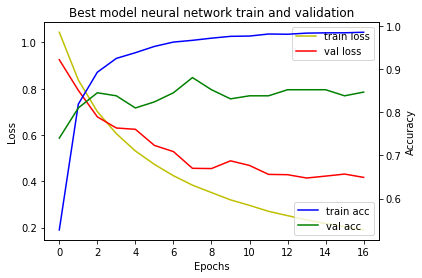

Wall time: 8h 24min 26s


In [25]:
%%time
search_result = gp_minimize(func=fitness, dimensions=dimensions, acq_func='EI', n_calls=40, x0=default_parameters)

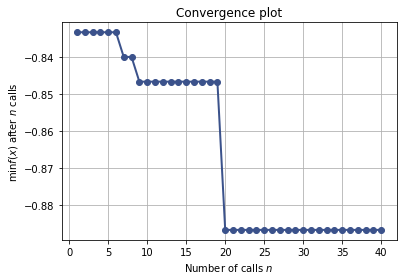

In [26]:
plot_convergence(search_result)

In [27]:
search_result.x

[0.00012946928271548072, 3, 5]

In [28]:
search_result.fun

-0.88666666547457373

In [29]:
new_model = load_model(path_best_model)

In [30]:
generator_test.reset()
result = new_model.evaluate_generator(generator_test)

In [31]:
for name, value in zip(new_model.metrics_names, result):
  print(name, value)

loss 0.588457826035
acc 0.88815789356


In [32]:
result

[0.58845782603480312, 0.88815789356043462]

여기까지가 GP를 이용한 Bayesian-optimizer method

In [33]:
class_name = os.listdir('./aug_train1')

In [34]:
train_dir = './aug_train1'
test_dir = './valid1'


In [35]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [36]:
len(generator_train.filenames)
len(generator_test.filenames)

152

In [37]:

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [38]:

cls_train = generator_train.classes
cls_test = generator_test.classes

In [39]:
class_names = os.listdir('./aug_train1')
class_names

['1gr', '2gr', '3gr']

In [40]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [41]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    re = classification_report(y_true=cls_test,
                               y_pred=cls_pred)
    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    print(re)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [42]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [43]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [44]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

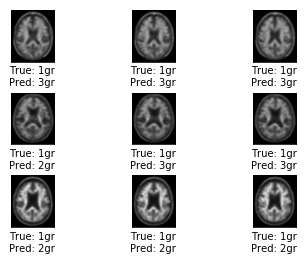

Confusion matrix:
[[62  6  5]
 [ 0 17  3]
 [ 0  3 56]]
             precision    recall  f1-score   support

          0       1.00      0.85      0.92        73
          1       0.65      0.85      0.74        20
          2       0.88      0.95      0.91        59

avg / total       0.91      0.89      0.89       152

(0) 1gr
(1) 2gr
(2) 3gr


In [45]:
example_errors()